# DeepSleepNet-Lite: Reproduction & Student Extensions

**Fill your names here**  
**Course:** cs584 f25 – Final Project  
**Generated:** 2025-11-03 19:18

> This notebook reproduces a light, two-branch 1D CNN for single-channel EEG sleep staging (sequence-to-epoch with 90 seconds of context) and adds:
> - Uniform and structured label smoothing
> - Monte Carlo Dropout uncertainty
> - Proper evaluation: Accuracy, Macro-F1, Weighted-F1, Cohen's kappa
> - Calibration via ECE and reliability diagrams
> - Selective prediction (reject the least-confident q%)  
> All comments target students: we explain *what*, *why*, and *how* in practical terms.

## 0. Environment & Reproducibility
We install/verify packages, print versions, and set seeds. If internet installs are blocked on your machine, pre-install the listed packages and re-run.

In [29]:
import sys, subprocess, importlib, os, random, json, math, time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, cohen_kappa_score
from tqdm import tqdm
import glob
import mne
import os
from pathlib import Path

def set_seeds(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## 1. Configuration
Centralized hyper-parameters and paths. The entire notebook reads from this dictionary.

In [30]:
CONFIG = {
    "dataset": "sleep-edf",
    "target_channel": "Fpz-Cz",
    "epoch_seconds": 30,
    "context_epochs": 3,             # 90 seconds = 3 x 30s
    "fs": 100,
    "use_in_bed_only": False,

    "cv_folds": 5,
    "val_ratio": 0.1,
    "seed": 42,

    "batch_size": 128,
    "max_epochs": 25,
    "learning_rate": 1e-4,
    "weight_decay": 1e-3,
    "patience": 5,
    "device": "cuda" if torch.cuda.is_available() else "cpu",

    "small_kernel": 7,
    "large_kernel": 49,
    "n_filters": 64,
    "dropout_p": 0.5,

    "label_smoothing": "uniform",    # "none" | "uniform" | "structured"
    "ls_alpha": 0.1,

    "mc_dropout_samples": 30,
    "balance_strategy": "oversample_and_flip",
    "num_workers": 2,

    "artifacts_dir": "artifacts", # select directory for artifacts
}
os.makedirs(CONFIG["artifacts_dir"], exist_ok=True)
with open(os.path.join(CONFIG["artifacts_dir"], "config.json"), "w") as f:
    json.dump(CONFIG, f, indent=2)
CONFIG

{'dataset': 'sleep-edf',
 'target_channel': 'Fpz-Cz',
 'epoch_seconds': 30,
 'context_epochs': 3,
 'fs': 100,
 'use_in_bed_only': False,
 'cv_folds': 5,
 'val_ratio': 0.1,
 'seed': 42,
 'batch_size': 128,
 'max_epochs': 25,
 'learning_rate': 0.0001,
 'weight_decay': 0.001,
 'patience': 5,
 'device': 'cpu',
 'small_kernel': 7,
 'large_kernel': 49,
 'n_filters': 64,
 'dropout_p': 0.5,
 'label_smoothing': 'uniform',
 'ls_alpha': 0.1,
 'mc_dropout_samples': 30,
 'balance_strategy': 'oversample_and_flip',
 'num_workers': 2,
 'artifacts_dir': 'artifacts'}

## 2. Dataset handling
We target Sleep-EDF (Fpz-Cz @ 100 Hz). To keep the notebook runnable everywhere, we provide a **synthetic fallback** if EDF files are not present or cannot be downloaded. Replace the fallback with real parsing for your full results.

In [31]:
DATA_ROOT = os.path.join(CONFIG["artifacts_dir"], "sleep_edf")
os.makedirs(DATA_ROOT, exist_ok=True)

STAGE_MAP = {"W":0,"N1":1,"N2":2,"N3":3,"R":4}
IDX2STAGE = {v:k for k,v in STAGE_MAP.items()}

def build_synthetic_dataset(n_subjects=4, epochs_per_subject=600, fs=100, epoch_sec=30):
    rng = np.random.default_rng(CONFIG["seed"])
    X, y, subj = [], [], []
    for s in range(n_subjects):
        stages = rng.choice([0,1,2,3,4], size=epochs_per_subject, p=[0.2,0.1,0.45,0.15,0.1])
        samples = fs*epoch_sec
        signal = rng.normal(0, 1, size=(epochs_per_subject, samples))
        X.append(signal); y.append(stages); subj += [f"SYN{s:02d}"]*epochs_per_subject
    return np.vstack(X), np.hstack(y), np.array(subj)

# For the template we use synthetic data so the rest of the pipeline is executable.
X_epochs, y_epochs, subjects = build_synthetic_dataset(n_subjects=5, epochs_per_subject=10)
print("Epochs:", X_epochs.shape, "Labels:", y_epochs.shape, "Subjects:", subjects.shape)

def build_context_windows(Xe, ye, sub, context_epochs=3):
    assert context_epochs == 3
    Xw, yw, sw = [], [], []
    for i in range(1, len(ye)-1):
        win = np.concatenate([Xe[i-1], Xe[i], Xe[i+1]], axis=0)
        Xw.append(win); yw.append(ye[i]); sw.append(sub[i])
    Xw = np.vstack([np.array(x)[None,:] for x in Xw])
    return Xw.astype(np.float32), np.array(yw).astype(np.int64), np.array(sw)

print("Loaded real Sleep-EDF epochs:", X_epochs.shape, "labels:", y_epochs.shape, "subjects:", subjects.shape)

X_win, y_win, subj_win = build_context_windows(X_epochs, y_epochs, subjects, CONFIG["context_epochs"])

def balance_data(X, y):
    classes, counts = np.unique(y, return_counts=True)
    max_c = counts.max()
    Xb, yb = [], []
    rng = np.random.default_rng(CONFIG["seed"])
    for c in classes:
        idx = np.where(y == c)[0]
        Xi, yi = X[idx], y[idx]
        Xi_aug = np.concatenate([Xi, -Xi], axis=0)
        yi_aug = np.concatenate([yi, yi], axis=0)
        if len(Xi_aug) < max_c:
            extra = rng.choice(len(Xi_aug), size=max_c-len(Xi_aug), replace=True)
            Xi_aug = np.concatenate([Xi_aug, Xi_aug[extra]], axis=0)
            yi_aug = np.concatenate([yi_aug, yi_aug[extra]], axis=0)
        else:
            Xi_aug = Xi_aug[:max_c]; yi_aug = yi_aug[:max_c]
        Xb.append(Xi_aug); yb.append(yi_aug)
    Xb = np.concatenate(Xb, axis=0); yb = np.concatenate(yb, axis=0)
    perm = rng.permutation(len(yb))
    return Xb[perm], yb[perm]

if CONFIG["balance_strategy"] == "oversample_and_flip":
    X_bal, y_bal = balance_data(X_win, y_win)
else:
    X_bal, y_bal = X_win, y_win

print("Balanced windows:", X_bal.shape, "Labels:", y_bal.shape)

print(X_bal)
print(y_bal)

Epochs: (50, 3000) Labels: (50,) Subjects: (50,)
Loaded real Sleep-EDF epochs: (50, 3000) labels: (50,) subjects: (50,)
Balanced windows: (85, 9000) Labels: (85,)
[[-0.44489047  4.5850677  -0.4821664  ...  0.908452    1.0281508
  -1.5792346 ]
 [ 0.8175577   0.3118025  -0.6784274  ...  0.34747177  0.9112158
   1.1734957 ]
 [ 0.18893239 -2.4683883  -1.0568706  ... -1.1552731   0.05100342
   1.789432  ]
 ...
 [-1.0610845  -0.22497508  1.5392872  ... -1.8704202   0.58673763
  -0.25032824]
 [ 1.0610845   0.22497508 -1.5392872  ...  1.8704202  -0.58673763
   0.25032824]
 [-1.6407346   0.70457643  0.76333886 ...  0.47536257 -1.4044222
  -0.79024714]]
[3 1 4 1 1 2 3 1 3 2 0 1 1 2 4 0 4 3 0 3 0 2 1 4 0 3 3 1 4 4 2 0 4 4 0 1 2
 3 1 0 4 0 3 0 2 4 3 0 4 0 1 4 2 4 1 3 1 2 4 0 2 3 3 2 0 3 1 0 2 4 3 2 1 3
 4 3 2 0 2 0 4 2 1 1 2]


In [ ]:

DATA_ROOT = os.path.join(CONFIG["artifacts_dir"], "sleep_edf")
os.makedirs(DATA_ROOT, exist_ok=True)

STAGE_MAP = {"W":0,"N1":1,"N2":2,"N3":3,"R":4}
IDX2STAGE = {v:k for k,v in STAGE_MAP.items()}


FS_TARGET = CONFIG["fs"]                 # 100 Hz
EPOCH_SEC = CONFIG["epoch_seconds"]      # 30 s
USE_IN_BED_ONLY = CONFIG["use_in_bed_only"]

# Map MNE annotation labels to 5 classes {W, N1, N2, N3, R}
def stage_label_to_int(desc: str):
    # Typical MNE descriptions: "Sleep stage W", "Sleep stage 1", "Sleep stage 2",
    # "Sleep stage 3", "Sleep stage 4", "Sleep stage R", "Sleep stage ?",
    # sometimes "Movement time".
    d = (desc or "").strip().upper()
    if "SLEEP STAGE W" in d:
        return 0  # W
    if "SLEEP STAGE R" in d:
        return 4  # REM
    if "SLEEP STAGE 1" in d:
        return 1  # N1
    if "SLEEP STAGE 2" in d:
        return 2  # N2
    if "SLEEP STAGE 3" in d or "SLEEP STAGE 4" in d:
        return 3  # N3 (merge N3+N4)
    # ignore movement or unknown
    return None

def find_psg_hyp_pairs(root):
    """
    Return a list of (psg_path, hyp_path) pairs found under `root`.
    Robust to variations in Sleep-EDF directory structures and naming (e.g., E0 vs EC).
    """

    root = Path(root)

    # 1) Find ALL PSG files recursively within the root directory.
    #    This includes subfolders like 'sleep-cassette' or others.
    psgs = sorted(glob.glob(str(root / "**" / "*-PSG.edf"), recursive=True))

    pairs = []
    for psg in psgs:
        psg_path = Path(psg)
        folder = psg_path.parent

        # 2) Find all candidate hypnogram files in the same folder.
        hyps = sorted(glob.glob(str(folder / "*Hypnogram*.edf")))

        if not hyps:
            # If no hypnograms exist in this folder, search recursively across all subfolders.
            hyps = sorted(glob.glob(str(root / "**" / "*Hypnogram*.edf"), recursive=True))

        # 3) Match PSG and Hypnogram by subject prefix (e.g., "SC4001").
        #    This works well for Sleep-EDF since filenames share the same prefix.
        subj_prefix = os.path.basename(psg)[:6]  # Example: "SC4001"
        hyp_match = None
        for h in hyps:
            if os.path.basename(h).startswith(subj_prefix):
                hyp_match = h
                break

        # 4) If no matching prefix found but hypnograms exist, pick the first one as fallback.
        if hyp_match is None and hyps:
            hyp_match = hyps[0]

        # 5) Store valid PSG/Hypnogram pairs.
        if hyp_match is not None and os.path.exists(hyp_match):
            pairs.append((str(psg_path), str(hyp_match)))

    return pairs

def pick_fpz_cz_channel(raw: mne.io.BaseRaw):
    """Pick Fpz-Cz channel (or the closest match). Returns channel name."""
    chs = [ch.upper() for ch in raw.ch_names]
    # exact or partial matches
    for key in ["EEG Fpz-Cz", "FPZ-CZ", "EEG FPZ-CZ", "FPZCZ", "FPZ-CZ"]:
        for orig in raw.ch_names:
            if key == orig.upper():
                return orig
    # heuristic partial search
    for orig in raw.ch_names:
        u = orig.upper()
        if "FPZ" in u and "CZ" in u:
            return orig
    # fallback: first EEG channel
    picks = mne.pick_types(raw.info, eeg=True, eog=False, emg=False)
    if len(picks) == 0:
        raise RuntimeError("No EEG channel found in this record.")
    return raw.ch_names[picks[0]]

def get_lights_on_off(annotations: mne.Annotations):
    """Return (lights_off_time_sec, lights_on_time_sec) if present; else (None,None)."""
    lo, li = None, None
    for onset, duration, desc in zip(annotations.onset, annotations.duration, annotations.description):
        d = (desc or "").lower()
        if "lights off" in d and lo is None:
            lo = onset
        if "lights on" in d and li is None:
            li = onset
    return lo, li

def extract_epochs_from_record(psg_path, hyp_path, fs_target=100, epoch_sec=30, use_in_bed_only=False):
    """Return X_epochs [N, fs*epoch_sec], y_epochs [N], subject_id [N]."""
    # Load raw PSG
    raw = mne.io.read_raw_edf(psg_path, preload=True, verbose="ERROR")
    # Read hypnogram annotations
    hyp = mne.read_annotations(hyp_path)
    raw.set_annotations(hyp)  # attach hypnogram to raw timeline

    # Pick Fpz-Cz (or best match) and resample to fs_target if needed
    ch = pick_fpz_cz_channel(raw)
    raw.pick_channels([ch])
    if abs(raw.info["sfreq"] - fs_target) > 1e-6:
        raw.resample(fs_target)

    # Determine time window: full or in-bed only
    tmin, tmax = 0.0, raw.times[-1]
    if use_in_bed_only:
        lo, li = get_lights_on_off(raw.annotations)
        if lo is not None and li is not None and li > lo:
            tmin, tmax = lo, li

    # Build 30s epochs grid
    n_samples_epoch = int(fs_target * epoch_sec)
    start_sample = int(tmin * fs_target)
    end_sample   = int(tmax * fs_target)
    # Align to epoch boundary
    start_sample = (start_sample // n_samples_epoch) * n_samples_epoch
    end_sample   = (end_sample   // n_samples_epoch) * n_samples_epoch

    # Prepare a fast label lookup from annotations
    # For each epoch, we take the label at the epoch midpoint
    labels = []
    X = []
    for s0 in range(start_sample, end_sample, n_samples_epoch):
        s1 = s0 + n_samples_epoch
        mid_time = (s0 + s1) / 2.0 / fs_target  # seconds

        # Find annotation active at mid_time
        lab = None
        for onset, duration, desc in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            if onset <= mid_time < onset + duration:
                lab = stage_label_to_int(desc)
                break

        if lab is None:
            # Unknown or movement time -> skip this epoch
            continue

        # Extract data for this epoch and z-score normalize per-epoch
        x = raw.get_data(start=s0, stop=s1)[0]  # channel already picked -> shape [T]
        mu, sd = x.mean(), x.std() + 1e-8
        x = (x - mu) / sd

        X.append(x.astype(np.float32))
        labels.append(lab)

    X = np.stack(X, axis=0) if len(X) else np.empty((0, n_samples_epoch), dtype=np.float32)
    y = np.array(labels, dtype=np.int64)

    # Subject id from filename prefix (e.g., SC4001E0)
    sid = os.path.basename(psg_path).split("-")[0]
    subj = np.array([sid] * len(y))
    return X, y, subj

# ---- Load all pairs ----
pairs = find_psg_hyp_pairs(DATA_ROOT)
if not pairs:
    raise RuntimeError(
        f"No PSG/Hypnogram pairs found under {DATA_ROOT}. "
        f"Place Sleep-EDF files (sleep-cassette/*-PSG.edf and *-Hypnogram.edf) there."
    )

X_list, y_list, s_list = [], [], []
for psg, hyp in pairs:
    Xi, yi, si = extract_epochs_from_record(
        psg, hyp, fs_target=FS_TARGET, epoch_sec=EPOCH_SEC, use_in_bed_only=USE_IN_BED_ONLY
    )
    if len(yi) == 0:
        print(f"[WARN] No labeled epochs from {psg} (after filtering). Skipping.")
        continue
    X_list.append(Xi); y_list.append(yi); s_list.append(si)

X_epochs = np.concatenate(X_list, axis=0)
y_epochs = np.concatenate(y_list, axis=0)
subjects = np.concatenate(s_list, axis=0)

print("Loaded real Sleep-EDF epochs:", X_epochs.shape, "labels:", y_epochs.shape, "subjects:", subjects.shape)
# ===== End of EDF parser block =====


print("Epochs:", X_epochs.shape, "Labels:", y_epochs.shape, "Subjects:", subjects.shape)


def build_context_windows(Xe, ye, sub, context_epochs=3):
    assert context_epochs == 3
    Xw, yw, sw = [], [], []
    for i in range(1, len(ye)-1):
        win = np.concatenate([Xe[i-1], Xe[i], Xe[i+1]], axis=0)
        Xw.append(win); yw.append(ye[i]); sw.append(sub[i])
    Xw = np.vstack([np.array(x)[None,:] for x in Xw])
    return Xw.astype(np.float32), np.array(yw).astype(np.int64), np.array(sw)

X_win, y_win, subj_win = build_context_windows(X_epochs, y_epochs, subjects, CONFIG["context_epochs"])

def balance_data(X, y):
    classes, counts = np.unique(y, return_counts=True)
    max_c = counts.max()
    Xb, yb = [], []
    rng = np.random.default_rng(CONFIG["seed"])
    for c in classes:
        idx = np.where(y == c)[0]
        Xi, yi = X[idx], y[idx]
        Xi_aug = np.concatenate([Xi, -Xi], axis=0)
        yi_aug = np.concatenate([yi, yi], axis=0)
        if len(Xi_aug) < max_c:
            extra = rng.choice(len(Xi_aug), size=max_c-len(Xi_aug), replace=True)
            Xi_aug = np.concatenate([Xi_aug, Xi_aug[extra]], axis=0)
            yi_aug = np.concatenate([yi_aug, yi_aug[extra]], axis=0)
        else:
            Xi_aug = Xi_aug[:max_c]; yi_aug = yi_aug[:max_c]
        Xb.append(Xi_aug); yb.append(yi_aug)
    Xb = np.concatenate(Xb, axis=0); yb = np.concatenate(yb, axis=0)
    perm = rng.permutation(len(yb))
    return Xb[perm], yb[perm]

if CONFIG["balance_strategy"] == "oversample_and_flip":
    X_bal, y_bal = balance_data(X_win, y_win)
else:
    X_bal, y_bal = X_win, y_win

print("Balanced windows:", X_bal.shape, "Labels:", y_bal.shape)

## 3. Model: two-branch 1D CNN (DeepSleepNet-Lite style)
Small kernels capture fine temporal features; large kernels capture broader spectral context. We keep parameter count modest and avoid RNNs.

In [32]:
import torch.nn as nn

class ConvBlock(nn.Module):
    # Conv1d -> BN -> ReLU -> MaxPool
    def __init__(self, in_ch, out_ch, k, pool=2):
        super().__init__()
        self.conv = nn.Conv1d(in_ch, out_ch, kernel_size=k, padding=k//2)
        self.bn = nn.BatchNorm1d(out_ch, eps=1e-5, momentum=0.999)
        self.act = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool1d(pool)
    def forward(self, x):
        return self.pool(self.act(self.bn(self.conv(x))))

class DeepSleepNetLite(nn.Module):
    # Input: [B, 1, T]; Output: class logits for 5 stages
    def __init__(self, n_classes=5, nf=64, k_small=7, k_large=49, p_drop=0.5):
        super().__init__()
        self.s1 = ConvBlock(1, nf, k_small)
        self.s2 = ConvBlock(nf, nf, k_small)
        self.s3 = ConvBlock(nf, 2*nf, k_small)
        self.s4 = ConvBlock(2*nf, 2*nf, k_small)

        self.l1 = ConvBlock(1, nf, k_large)
        self.l2 = ConvBlock(nf, nf, k_large)
        self.l3 = ConvBlock(nf, 2*nf, k_large)
        self.l4 = ConvBlock(2*nf, 2*nf, k_large)

        self.drop = nn.Dropout(p_drop)
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(4*nf, n_classes)
        )

    def forward(self, x):
        xs = self.s4(self.s3(self.s2(self.s1(x))))
        xl = self.l4(self.l3(self.l2(self.l1(x))))
        xcat = torch.cat([xs, xl], dim=1)
        xcat = self.drop(xcat)
        return self.head(xcat)

# Simple shape check
tmp = torch.randn(2,1,CONFIG["fs"]*CONFIG["epoch_seconds"]*CONFIG["context_epochs"])
print("Logits shape:", DeepSleepNetLite().forward(tmp).shape)

Logits shape: torch.Size([2, 5])


## 4. Label smoothing
Uniform (LSu) mixes one-hot with uniform; structured (LSs) mixes one-hot with an empirical transition-based distribution M(prev,:,next) estimated from training labels.

In [33]:
def make_uniform_targets(y, n_classes=5, alpha=0.1, device="cpu"):
    off = alpha / n_classes
    on = 1.0 - alpha + off
    tgt = torch.full((len(y), n_classes), off, dtype=torch.float32, device=device)
    tgt[torch.arange(len(y)), y] = on
    return tgt

def estimate_M_structured(y_sequence, n_classes=5):
    M = np.ones((n_classes, n_classes, n_classes), dtype=np.float64)  # Laplace smoothing
    for i in range(1, len(y_sequence)-1):
        p, c, n = y_sequence[i-1], y_sequence[i], y_sequence[i+1]
        M[p, c, n] += 1.0
    # normalize over middle dimension
    M = M / M.sum(axis=1, keepdims=True)
    M = M / M.sum(axis=2, keepdims=True)
    return M

def make_structured_targets(y, y_prev, y_next, M, alpha=0.2, n_classes=5, device="cpu"):
    B = len(y)
    tgt = torch.zeros((B, n_classes), dtype=torch.float32, device=device)
    for i in range(B):
        vec = torch.tensor(M[y_prev[i].item(), :, y_next[i].item()], dtype=torch.float32, device=device)
        vec = vec / (vec.sum() + 1e-8)
        tgt[i] = (1.0 - alpha) * F.one_hot(y[i], n_classes).float() + alpha * vec
    return tgt

## 5. Dataset wrapper and CV splits (by subject)
We wrap arrays into a Dataset that also carries prev/next labels for LSs, and create subject-wise folds.

In [34]:
class SleepWindows(Dataset):
    def __init__(self, X, y, subj, prev_labels, next_labels):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        self.subj = np.array(subj)
        self.prev = prev_labels.astype(np.int64)
        self.next = next_labels.astype(np.int64)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        x = self.X[idx][None, :]  # [1, T]
        return x, self.y[idx], self.prev[idx], self.next[idx]

prev_arr = np.concatenate([[y_bal[0]], y_bal[:-1]])
next_arr = np.concatenate([y_bal[1:], [y_bal[-1]]])
dataset = SleepWindows(X_bal, y_bal, subj_win[:len(y_bal)], prev_arr, next_arr)

uniq_subj = sorted(list(set(dataset.subj)))
rng = np.random.default_rng(CONFIG["seed"])
rng.shuffle(uniq_subj)
folds = np.array_split(uniq_subj, CONFIG["cv_folds"])
print("Folds (subjects):", [list(f) for f in folds])



Folds (subjects): [[np.str_('SYN04')], [np.str_('SYN02')], [np.str_('SYN03')], [np.str_('SYN01')], [np.str_('SYN00')]]


## 6. Utilities: Early stopping, ECE, reliability plot

In [35]:
def ece_score(confidences, correctness, n_bins=15):
    bins = np.linspace(0., 1., n_bins+1)
    ece = 0.0
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        sel = (confidences > lo) & (confidences <= hi)
        if sel.sum() == 0: continue
        acc = correctness[sel].mean()
        conf = confidences[sel].mean()
        ece += (sel.sum() / len(confidences)) * abs(acc - conf)
    return float(ece)

def plot_reliability(confidences, correctness, n_bins=15):
    bins = np.linspace(0., 1., n_bins+1)
    xs, ys = [], []
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        sel = (confidences > lo) & (confidences <= hi)
        if sel.sum() == 0: continue
        xs.append(correctness[sel].mean()); ys.append(confidences[sel].mean())
    plt.figure()
    plt.plot([0,1],[0,1],'--', linewidth=1)
    plt.scatter(xs, ys)
    plt.xlabel("Accuracy per bin"); plt.ylabel("Mean confidence per bin"); plt.title("Reliability Diagram")

class EarlyStopper:
    def __init__(self, patience=5):
        self.best = None; self.wait = 0; self.pat = patience; self.state=None
    def step(self, metric, model):
        if self.best is None or metric > self.best:
            self.best = metric; self.wait = 0
            self.state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
            return False
        self.wait += 1
        return self.wait > self.pat

## 7. Train per fold
We train with the selected label smoothing strategy and early stopping on macro-F1 (more robust to class imbalance).

In [36]:
def indices_for_fold(fold_id):
    test_subj = set(folds[fold_id])
    train_subj = set().union(*[set(f) for i,f in enumerate(folds) if i!=fold_id])
    train_mask = np.array([s in train_subj for s in dataset.subj])
    test_mask  = np.array([s in test_subj  for s in dataset.subj])
    idx_train_all = np.where(train_mask)[0]
    idx_test = np.where(test_mask)[0]
    rng = np.random.default_rng(CONFIG["seed"] + fold_id)
    perm = rng.permutation(len(idx_train_all))
    n_val = max(1, int(CONFIG["val_ratio"] * len(idx_train_all)))
    idx_val = idx_train_all[perm[:n_val]]
    idx_train = idx_train_all[perm[n_val:]]
    return idx_train, idx_val, idx_test

def run_fold(train_idx, val_idx, test_idx, data):
    set_seeds(CONFIG["seed"])
    device = CONFIG["device"]
    model = DeepSleepNetLite(nf=CONFIG["n_filters"],
                             k_small=CONFIG["small_kernel"],
                             k_large=CONFIG["large_kernel"],
                             p_drop=CONFIG["dropout_p"]).to(device)
    opt = optim.Adam(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=CONFIG["weight_decay"])

    def make_loader(idxs, shuffle):
        subset = torch.utils.data.Subset(data, idxs.tolist())
        return DataLoader(subset, batch_size=CONFIG["batch_size"], shuffle=shuffle,
                          num_workers=CONFIG["num_workers"], drop_last=False)

    train_loader = make_loader(train_idx, True)
    val_loader   = make_loader(val_idx, False)

    M = estimate_M_structured(data.y[train_idx]) if CONFIG["label_smoothing"] == "structured" else None
    stopper = EarlyStopper(CONFIG["patience"])
    history = []
    best_epoch = -1

    for epoch in range(1, CONFIG["max_epochs"]+1):
        model.train()
        losses = []
        for xb, yb, pb, nb in train_loader:
            xb, yb, pb, nb = xb.to(device), yb.to(device), pb.to(device), nb.to(device)
            logits = model(xb)
            if CONFIG["label_smoothing"] == "uniform":
                targets = make_uniform_targets(yb, n_classes=5, alpha=CONFIG["ls_alpha"], device=device)
                loss = -(targets * F.log_softmax(logits, dim=1)).sum(dim=1).mean()
            elif CONFIG["label_smoothing"] == "structured":
                targets = make_structured_targets(yb, pb, nb, M, alpha=CONFIG["ls_alpha"], device=device)
                loss = -(targets * F.log_softmax(logits, dim=1)).sum(dim=1).mean()
            else:
                loss = F.cross_entropy(logits, yb)
            opt.zero_grad(); loss.backward(); opt.step()
            losses.append(loss.item())

        model.eval()
        y_true, y_pred, y_conf = [], [], []
        with torch.no_grad():
            for xb, yb, _, _ in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                probs = F.softmax(model(xb), dim=1)
                conf, pred = probs.max(dim=1)
                y_true.extend(yb.cpu().numpy()); y_pred.extend(pred.cpu().numpy()); y_conf.extend(conf.cpu().numpy())
        acc = accuracy_score(y_true, y_pred)
        mf1 = f1_score(y_true, y_pred, average="macro")
        wf1 = f1_score(y_true, y_pred, average="weighted")
        kappa = cohen_kappa_score(y_true, y_pred)
        ece = ece_score(np.array(y_conf), (np.array(y_true)==np.array(y_pred)).astype(float))
        history.append({"epoch":epoch,"loss":float(np.mean(losses)),"acc":acc,"mf1":mf1,"wf1":wf1,"kappa":kappa,"ece":ece})
        print(f"Epoch {epoch:02d} | loss {np.mean(losses):.4f} | acc {acc:.3f} | MF1 {mf1:.3f} | k {kappa:.3f} | ECE {ece:.3f}")
        if stopper.step(mf1, model):
            print("Early stopping"); break
        else:
            best_epoch = epoch

    model.load_state_dict(stopper.state)
    return model, pd.DataFrame(history), best_epoch

## 8. Run K-fold CV, save models and histories

In [37]:
ALL = []
FOLD_RESULTS = []
for fid in range(len(folds)):
    print("\\n=== Fold", fid, "===")
    tr, va, te = indices_for_fold(fid)
    model, hist, best_ep = run_fold(tr, va, te, dataset)
    save_path = os.path.join(CONFIG["artifacts_dir"], f"model_fold{fid}.pt")
    torch.save(model.state_dict(), save_path)
    hist.to_csv(os.path.join(CONFIG["artifacts_dir"], f"history_fold{fid}.csv"), index=False)
    FOLD_RESULTS.append({"fold": fid, "best_epoch": int(best_ep), "model_path": save_path})
pd.DataFrame(FOLD_RESULTS)

\n=== Fold 0 ===
Epoch 01 | loss 1.6878 | acc 0.000 | MF1 0.000 | k 0.000 | ECE 0.281
Epoch 02 | loss 1.6380 | acc 0.000 | MF1 0.000 | k 0.000 | ECE 0.280
Epoch 03 | loss 1.5906 | acc 0.000 | MF1 0.000 | k 0.000 | ECE 0.286
Epoch 04 | loss 1.5542 | acc 0.000 | MF1 0.000 | k 0.000 | ECE 0.303
Epoch 05 | loss 1.5102 | acc 0.000 | MF1 0.000 | k 0.000 | ECE 0.327
Epoch 06 | loss 1.4635 | acc 0.000 | MF1 0.000 | k 0.000 | ECE 0.348
Epoch 07 | loss 1.4210 | acc 0.000 | MF1 0.000 | k 0.000 | ECE 0.371
Early stopping
\n=== Fold 1 ===
Epoch 01 | loss 1.6649 | acc 1.000 | MF1 1.000 | k 1.000 | ECE 0.757
Epoch 02 | loss 1.6211 | acc 0.667 | MF1 0.667 | k 0.400 | ECE 0.418
Epoch 03 | loss 1.5763 | acc 0.667 | MF1 0.667 | k 0.400 | ECE 0.419
Epoch 04 | loss 1.5421 | acc 0.333 | MF1 0.250 | k 0.000 | ECE 0.079
Epoch 05 | loss 1.5081 | acc 0.333 | MF1 0.250 | k 0.000 | ECE 0.234
Epoch 06 | loss 1.4664 | acc 0.333 | MF1 0.250 | k 0.000 | ECE 0.229
Epoch 07 | loss 1.4260 | acc 0.333 | MF1 0.250 | k 0.0

,fold,best_epoch,model_path
0,0,6,artifacts/model_fold0.pt
1,1,6,artifacts/model_fold1.pt
2,2,6,artifacts/model_fold2.pt
3,3,9,artifacts/model_fold3.pt
4,4,6,artifacts/model_fold4.pt


## 9. Test evaluation + MC Dropout + Selective prediction

[Fold 0] TEST std: acc 0.222 mf1 0.091 k 0.000 ece 0.063
[Fold 0] TEST MC30: acc 0.222 mf1 0.091 k 0.000 ece 0.063
[Fold 0] MC30 reject 5%: acc 0.250 mf1 0.100 k 0.000
[Fold 0] MC30 reject 10%: acc 0.250 mf1 0.100 k 0.000
[Fold 0] MC30 reject 20%: acc 0.286 mf1 0.111 k 0.000
[Fold 1] TEST std: acc 0.100 mf1 0.036 k 0.000 ece 0.145
[Fold 1] TEST MC30: acc 0.100 mf1 0.036 k 0.000 ece 0.145
[Fold 1] MC30 reject 5%: acc 0.111 mf1 0.040 k 0.000
[Fold 1] MC30 reject 10%: acc 0.111 mf1 0.040 k 0.000
[Fold 1] MC30 reject 20%: acc 0.125 mf1 0.044 k 0.000
[Fold 2] TEST std: acc 0.100 mf1 0.036 k 0.000 ece 0.172
[Fold 2] TEST MC30: acc 0.100 mf1 0.036 k 0.000 ece 0.172
[Fold 2] MC30 reject 5%: acc 0.111 mf1 0.040 k 0.000
[Fold 2] MC30 reject 10%: acc 0.111 mf1 0.040 k 0.000
[Fold 2] MC30 reject 20%: acc 0.125 mf1 0.044 k 0.000
[Fold 3] TEST std: acc 0.100 mf1 0.040 k -0.098 ece 0.155
[Fold 3] TEST MC30: acc 0.100 mf1 0.036 k -0.111 ece 0.156
[Fold 3] MC30 reject 5%: acc 0.111 mf1 0.040 k -0.125
[

,fold,mode,acc,mf1,wf1,kappa,ece
0,0,standard,0.222222,0.090909,0.080808,0.000000,0.062892
1,0,mc30,0.222222,0.090909,0.080808,0.000000,0.062620
2,0,mc30_reject_5,0.250000,0.100000,NaN,0.000000,NaN
3,0,mc30_reject_10,0.250000,0.100000,NaN,0.000000,NaN
4,0,mc30_reject_20,0.285714,0.111111,NaN,0.000000,NaN
5,1,standard,0.100000,0.036364,0.018182,0.000000,0.145049
6,1,mc30,0.100000,0.036364,0.018182,0.000000,0.144802
7,1,mc30_reject_5,0.111111,0.040000,NaN,0.000000,NaN
8,1,mc30_reject_10,0.111111,0.040000,NaN,0.000000,NaN
9,1,mc30_reject_20,0.125000,0.044444,NaN,0.000000,NaN


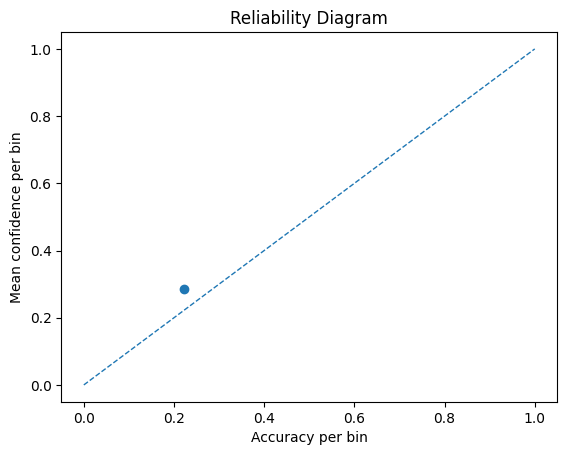

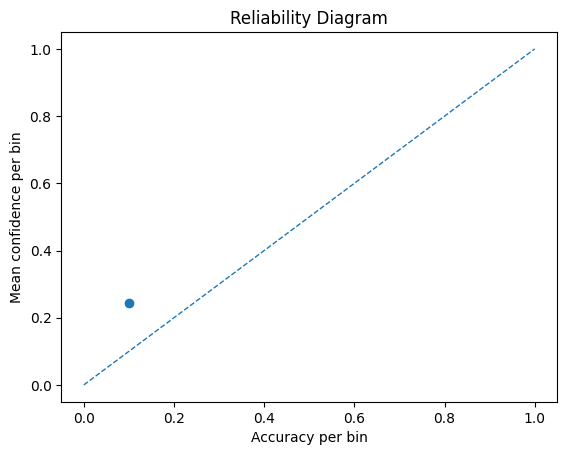

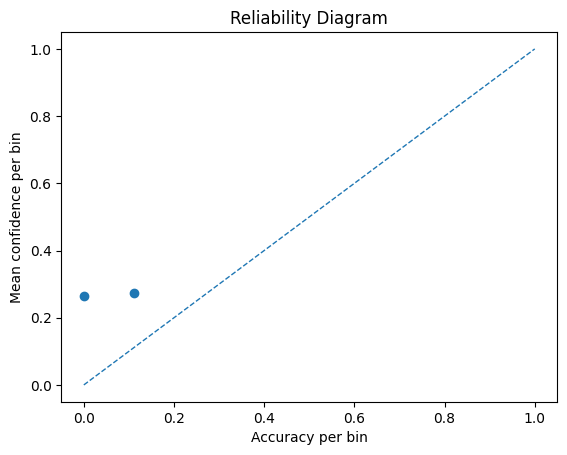

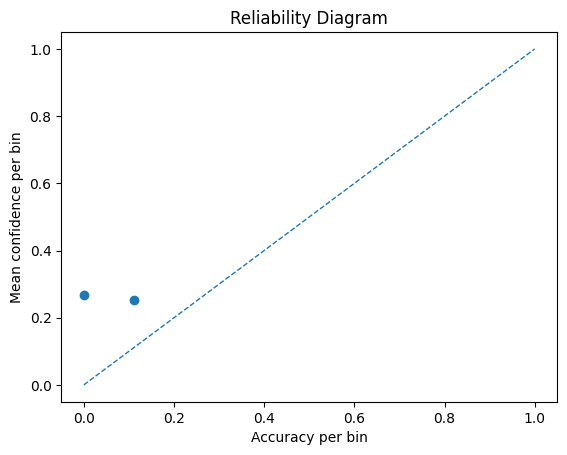

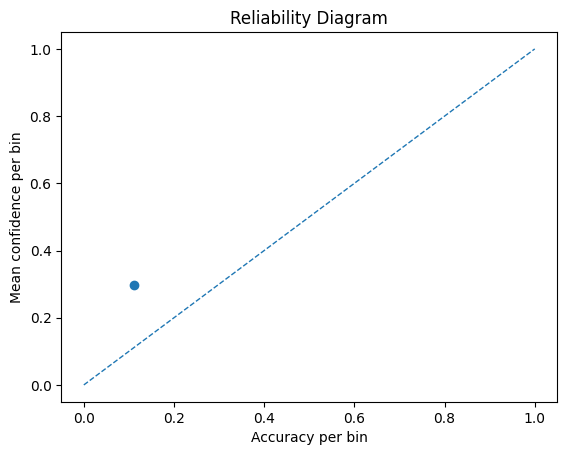

In [39]:
def enable_mc_dropout(m):
    for module in m.modules():
        if isinstance(module, nn.Dropout):
            module.train()

def evaluate_model(model, idxs, mc_samples=0):
    device = CONFIG["device"]
    loader = DataLoader(torch.utils.data.Subset(dataset, idxs.tolist()),
                        batch_size=CONFIG["batch_size"], shuffle=False,
                        num_workers=CONFIG["num_workers"], drop_last=False)
    y_true, y_pred, y_conf = [], [], []
    if mc_samples <= 0:
        model.eval()
        with torch.no_grad():
            for xb, yb, _, _ in loader:
                xb, yb = xb.to(device), yb.to(device)
                probs = F.softmax(model(xb), dim=1)
                conf, pred = probs.max(dim=1)
                y_true.extend(yb.cpu().numpy()); y_pred.extend(pred.cpu().numpy()); y_conf.extend(conf.cpu().numpy())
        return np.array(y_true), np.array(y_pred), np.array(y_conf)
    else:
        model.eval(); enable_mc_dropout(model)
        with torch.no_grad():
            for xb, yb, _, _ in loader:
                xb, yb = xb.to(device), yb.to(device)
                probs_mc = []
                for _ in range(mc_samples):
                    probs_mc.append(F.softmax(model(xb), dim=1).unsqueeze(0))
                probs_mc = torch.cat(probs_mc, dim=0)
                probs = probs_mc.mean(dim=0)
                conf, pred = probs.max(dim=1)
                y_true.extend(yb.cpu().numpy()); y_pred.extend(pred.cpu().numpy()); y_conf.extend(conf.cpu().numpy())
        return np.array(y_true), np.array(y_pred), np.array(y_conf)

ALL_METRICS = []
for rec in FOLD_RESULTS:
    fid = rec["fold"]
    _, _, idx_test = indices_for_fold(fid)

    model = DeepSleepNetLite(nf=CONFIG["n_filters"],
                             k_small=CONFIG["small_kernel"],
                             k_large=CONFIG["large_kernel"],
                             p_drop=CONFIG["dropout_p"]).to(CONFIG["device"])
    model.load_state_dict(torch.load(rec["model_path"], map_location=CONFIG["device"]))

    y_t, y_p, y_c = evaluate_model(model, idx_test, mc_samples=0)
    acc = accuracy_score(y_t, y_p); mf1 = f1_score(y_t, y_p, average="macro")
    wf1 = f1_score(y_t, y_p, average="weighted"); kappa = cohen_kappa_score(y_t, y_p)
    ece = ece_score(y_c, (y_t==y_p).astype(float))
    print(f"[Fold {fid}] TEST std: acc {acc:.3f} mf1 {mf1:.3f} k {kappa:.3f} ece {ece:.3f}")
    ALL_METRICS.append({"fold":fid,"mode":"standard","acc":acc,"mf1":mf1,"wf1":wf1,"kappa":kappa,"ece":ece})
    plot_reliability(y_c, (y_t==y_p).astype(float))

    S = CONFIG["mc_dropout_samples"]
    y_t2, y_p2, y_c2 = evaluate_model(model, idx_test, mc_samples=S)
    acc2 = accuracy_score(y_t2, y_p2); mf1_2 = f1_score(y_t2, y_p2, average="macro")
    wf1_2 = f1_score(y_t2, y_p2, average="weighted"); kappa2 = cohen_kappa_score(y_t2, y_p2)
    ece2 = ece_score(y_c2, (y_t2==y_p2).astype(float))
    print(f"[Fold {fid}] TEST MC{S}: acc {acc2:.3f} mf1 {mf1_2:.3f} k {kappa2:.3f} ece {ece2:.3f}")
    ALL_METRICS.append({"fold":fid,"mode":f"mc{S}","acc":acc2,"mf1":mf1_2,"wf1":wf1_2,"kappa":kappa2,"ece":ece2})

    for q in [0.05, 0.1, 0.2]:
        thr = np.quantile(y_c2, q)
        mask = y_c2 > thr
        if mask.sum()==0: continue
        acc_q = accuracy_score(y_t2[mask], y_p2[mask])
        mf1_q = f1_score(y_t2[mask], y_p2[mask], average="macro")
        kappa_q = cohen_kappa_score(y_t2[mask], y_p2[mask])
        print(f"[Fold {fid}] MC{S} reject {int(q*100)}%: acc {acc_q:.3f} mf1 {mf1_q:.3f} k {kappa_q:.3f}")
        ALL_METRICS.append({"fold":fid,"mode":f"mc{S}_reject_{int(q*100)}","acc":acc_q,"mf1":mf1_q,"wf1":None,"kappa":kappa_q,"ece":None})

pd.DataFrame(ALL_METRICS)

## 10. Qualitative inspection
We show a couple of sample windows with predicted distribution (mean if MC) to understand errors and uncertainty.

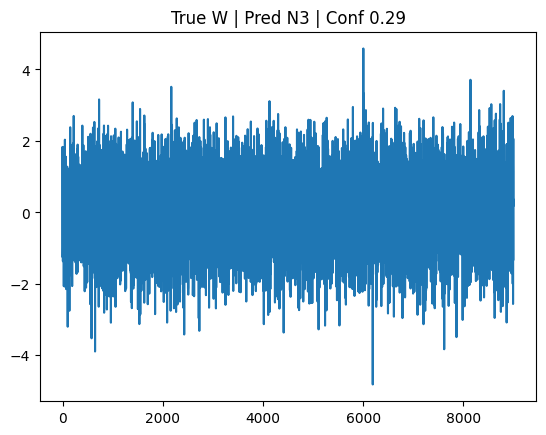

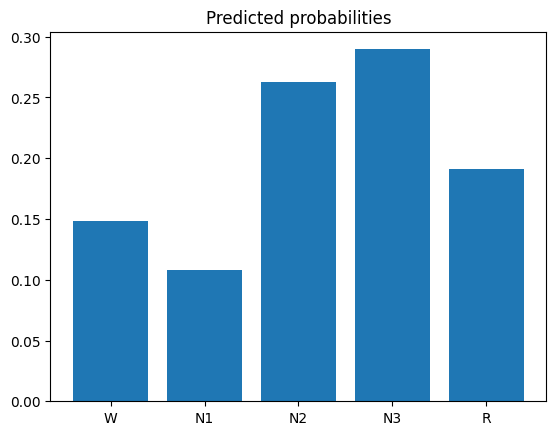

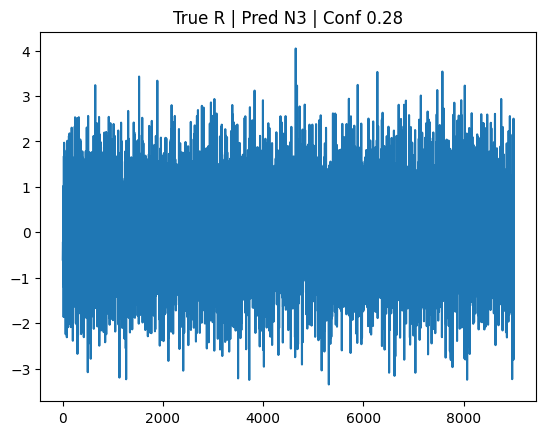

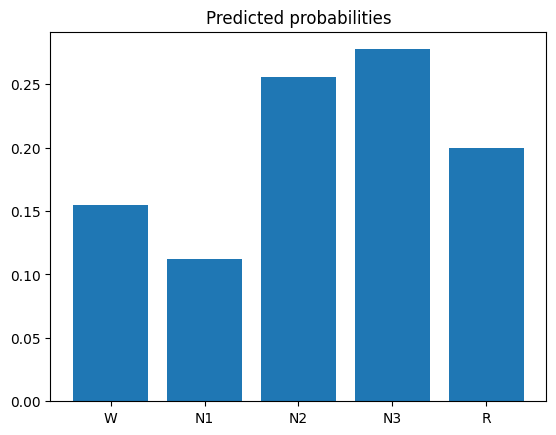

In [40]:
def show_examples(model, idxs, n=2, mc_samples=0):
    device = CONFIG["device"]
    loader = DataLoader(torch.utils.data.Subset(dataset, idxs.tolist()[:n]), batch_size=1, shuffle=False)
    model.eval()
    if mc_samples>0:
        for m in model.modules():
            if isinstance(m, nn.Dropout): m.train()
    with torch.no_grad():
        for xb, yb, _, _ in loader:
            xb = xb.to(device); gt = int(yb.item())
            if mc_samples>0:
                pm = []
                for _ in range(mc_samples):
                    pm.append(F.softmax(model(xb), dim=1).cpu().numpy()[0])
                probs = np.mean(pm, axis=0)
            else:
                probs = F.softmax(model(xb), dim=1).cpu().numpy()[0]
            pred = int(np.argmax(probs))
            plt.figure(); plt.plot(xb.cpu().numpy().ravel()); plt.title(f"True {IDX2STAGE[gt]} | Pred {IDX2STAGE[pred]} | Conf {probs[pred]:.2f}")
            plt.figure(); plt.bar(range(5), probs); plt.xticks(range(5), [IDX2STAGE[i] for i in range(5)]); plt.title("Predicted probabilities")

_, _, idx_test0 = indices_for_fold(0)
m0 = DeepSleepNetLite(nf=CONFIG["n_filters"], k_small=CONFIG["small_kernel"], k_large=CONFIG["large_kernel"], p_drop=CONFIG["dropout_p"]).to(CONFIG["device"])
m0.load_state_dict(torch.load(os.path.join(CONFIG["artifacts_dir"], "model_fold0.pt"), map_location=CONFIG["device"]))
show_examples(m0, idx_test0, n=2, mc_samples=CONFIG["mc_dropout_samples"])

## 11. Export artifacts for final submission
We save metrics, a minimal `model.txt`, `data.txt`, and a `requirements.txt` as requested by the brief.

In [41]:
metrics_path = os.path.join(CONFIG["artifacts_dir"], "metrics.csv")
pd.DataFrame(ALL_METRICS).to_csv(metrics_path, index=False)
print("Saved:", metrics_path)

with open(os.path.join(CONFIG["artifacts_dir"], "model.txt"), "w") as f:
    f.write("# Saved model weights (per fold)\n")
    for rec in os.listdir(CONFIG["artifacts_dir"]):
        if rec.startswith("model_fold") and rec.endswith(".pt"):
            f.write(rec + "\n")

with open(os.path.join(CONFIG["artifacts_dir"], "data.txt"), "w") as f:
    f.write("Sleep-EDF Expanded (Sleep Cassette). PhysioNet.\nPlace EDF files under artifacts/sleep_edf/ if auto-download is not available.\n")

reqs = [
    "numpy","scipy","pandas","matplotlib","scikit-learn",
    "torch==2.2.2","torchmetrics>=1.3.0","tqdm","wfdb","mne"
]
with open(os.path.join(CONFIG["artifacts_dir"], "requirements.txt"), "w") as f:
    f.write("\\n".join(reqs))

print("Artifacts in:", CONFIG["artifacts_dir"])

Saved: artifacts/metrics.csv
Artifacts in: artifacts
